# Final Task - Home Credit Scorecard Model

## 1. Project Overview
**Objective:** Membangun model prediksi risiko kredit yang robust menggunakan teknik Feature Engineering lanjut dan Ensemble Learning (LightGBM & XGBoost).

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, classification_report)

# Models
import lightgbm as lgb
import xgboost as xgb

# Settings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('husl')

## 2. Data Loading & Initial Exploration

Training Shape: (307511, 122)

Test Shape: (48744, 121)



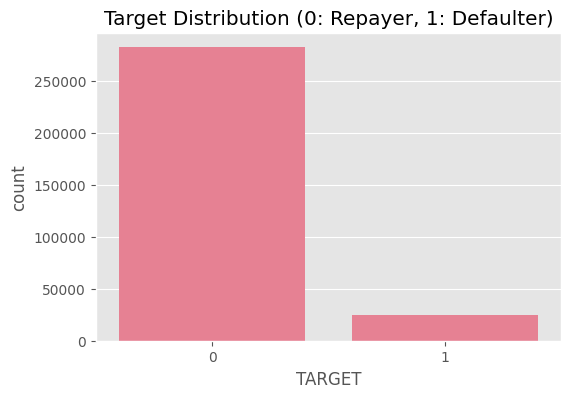

Default Rate: 8.07%


In [16]:
# Load Data
train_path = 'home-credit-default-risk/application_train.csv'
test_path = 'home-credit-default-risk/application_test.csv'

app_train = pd.read_csv(train_path)
app_test = pd.read_csv(test_path)

print(f"Training Shape: {app_train.shape}\n")
print(f"Test Shape: {app_test.shape}\n")

# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=app_train)
plt.title('Target Distribution (0: Repayer, 1: Defaulter)')
plt.show()

print(f"Default Rate: {app_train['TARGET'].mean()*100:.2f}%")

## 3. EDA (Insights)
*Menggali pola risiko berdasarkan Umur dan Pekerjaan.*

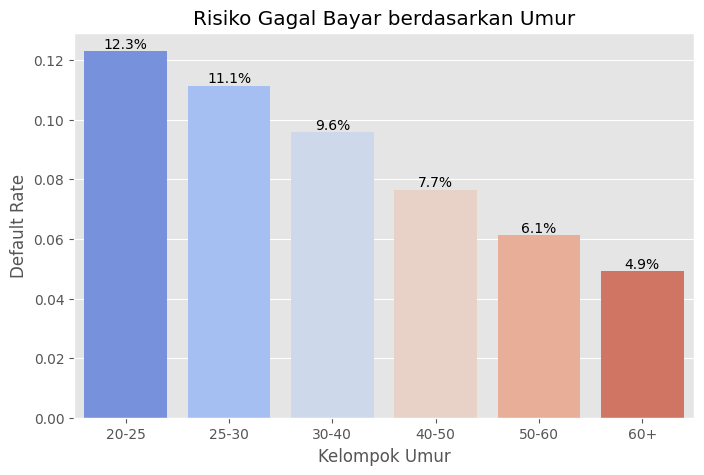

In [17]:
# Insight 1: Risiko Gagal Bayar per Kelompok Usia
app_train['AGE_YEARS'] = -app_train['DAYS_BIRTH'] / 365
bins = [20, 25, 30, 40, 50, 60, 70]
labels = ['20-25', '25-30', '30-40', '40-50', '50-60', '60+']
app_train['AGE_GROUP'] = pd.cut(app_train['AGE_YEARS'], bins=bins, labels=labels)

age_risk = app_train.groupby('AGE_GROUP')['TARGET'].mean().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='AGE_GROUP', y='TARGET', data=age_risk, palette='coolwarm')
plt.title('Risiko Gagal Bayar berdasarkan Umur')
plt.ylabel('Default Rate')
plt.xlabel('Kelompok Umur')

for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.show()

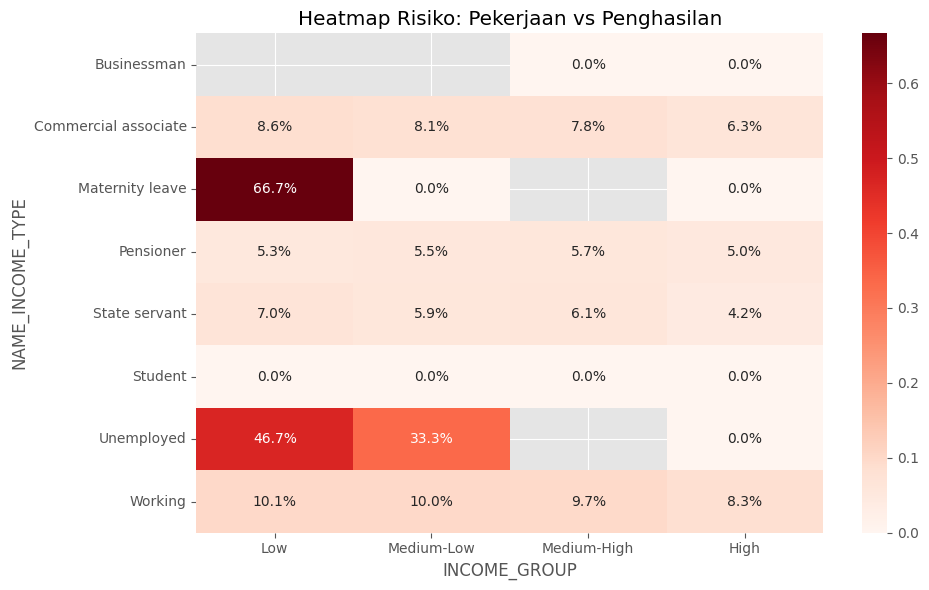

In [18]:
# Insight 2: Heatmap Pekerjaan vs Penghasilan
# Binning Income
app_train['INCOME_GROUP'] = pd.qcut(app_train['AMT_INCOME_TOTAL'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

pivot_risk = app_train.groupby(['NAME_INCOME_TYPE', 'INCOME_GROUP'])['TARGET'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_risk, annot=True, fmt='.1%', cmap='Reds')
plt.title('Heatmap Risiko: Pekerjaan vs Penghasilan')
plt.tight_layout()
plt.show()

## 4. Preprocessing & Feature Engineering
*Pembersihan data dan pembuatan fitur turunan.*

In [19]:
def preprocess_and_engineer(df, is_train=True):
    df = df.copy()
    
    # 1. Cleaning: Drop columns with >50% missing values
    # (Dalam praktiknya, kita simpan list kolom yang didrop dari train untuk diterapkan ke test)
    # Disini kita skip drop otomatis agar konsisten, tapi kita handle anomali
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # 2. Feature Engineering
    # Ratio Features
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / (df['AMT_CREDIT'] + 1)
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
    
    # Age & Employment
    df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365
    df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    # External Sources Aggregation
    ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    df['EXT_SOURCE_MEAN'] = df[ext_cols].mean(axis=1)
    df['EXT_SOURCE_STD'] = df[ext_cols].std(axis=1)
    
    return df

# Apply Feature Engineering
app_train_eng = preprocess_and_engineer(app_train, is_train=True)
app_test_eng = preprocess_and_engineer(app_test, is_train=False)

print("Feature Engineering Complete.")

Feature Engineering Complete.


In [20]:
# 3. Encoding & Imputation
# Hapus kolom bantu EDA
drop_cols_eda = ['AGE_GROUP', 'INCOME_GROUP']
app_train_eng.drop(columns=drop_cols_eda, errors='ignore', inplace=True)

# Label Encoding untuk Kategori
le = LabelEncoder()
le_count = 0

for col in app_train_eng.columns:
    if app_train_eng[col].dtype == 'object':
        if len(list(app_train_eng[col].unique())) <= 2:
            le.fit(app_train_eng[col].astype(str))
            app_train_eng[col] = le.transform(app_train_eng[col].astype(str))
            app_test_eng[col] = le.transform(app_test_eng[col].astype(str))
            le_count += 1

# One-Hot Encoding
app_train_eng = pd.get_dummies(app_train_eng)
app_test_eng = pd.get_dummies(app_test_eng)

# Align Columns
train_target = app_train_eng['TARGET']
app_train_eng, app_test_eng = app_train_eng.align(app_test_eng, join='inner', axis=1)
app_train_eng['TARGET'] = train_target

# Clean Column Names (untuk LightGBM)
app_train_eng = app_train_eng.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test_eng = app_test_eng.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Imputation (Median)
print("Imputing missing values...")
imputer = SimpleImputer(strategy='median')
train_cols = [c for c in app_train_eng.columns if c != 'TARGET']

app_train_eng[train_cols] = imputer.fit_transform(app_train_eng[train_cols])
app_test_eng[train_cols] = imputer.transform(app_test_eng[train_cols])

print("Preprocessing Complete.")

Imputing missing values...
Preprocessing Complete.


## 5. Model Training & Evaluation
*Melatih 3 Model: Logistic Regression, LightGBM, dan XGBoost.*

In [21]:
# Split Data
X = app_train_eng.drop(columns=['TARGET', 'SK_ID_CURR'])
y = app_train_eng['TARGET']
X_test_final = app_test_eng.drop(columns=['SK_ID_CURR'])

# Scaling (untuk LogReg)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train Size: {X_train.shape}, Validation Size: {X_val.shape}")

Train Size: (246008, 247), Validation Size: (61503, 247)


In [22]:
# MODEL 1: Logistic Regression (Baseline)
print("Training Logistic Regression...")
lr_model = LogisticRegression(C=0.0001, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict_proba(X_val)[:, 1]
auc_lr = roc_auc_score(y_val, y_pred_lr)
print(f"Logistic Regression AUC: {auc_lr:.4f}")

Training Logistic Regression...
Logistic Regression AUC: 0.7268


In [23]:
# MODEL 2: LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced', # Menangani Imbalance
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc')

y_pred_lgb = lgb_model.predict_proba(X_val)[:, 1]
auc_lgb = roc_auc_score(y_val, y_pred_lgb)
print(f"LightGBM AUC: {auc_lgb:.4f}")

Training LightGBM...
LightGBM AUC: 0.7660


In [24]:
# MODEL 3: XGBoost
print("Training XGBoost...")
# Hitung scale_pos_weight untuk imbalance
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    scale_pos_weight=ratio, # Menangani Imbalance
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

y_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

Training XGBoost...
[0]	validation_0-auc:0.72209
[100]	validation_0-auc:0.76128
[200]	validation_0-auc:0.76290
[300]	validation_0-auc:0.76124
[400]	validation_0-auc:0.75967
[500]	validation_0-auc:0.75781
[600]	validation_0-auc:0.75554
[700]	validation_0-auc:0.75333
[800]	validation_0-auc:0.75063
[900]	validation_0-auc:0.74883
[999]	validation_0-auc:0.74629
XGBoost AUC: 0.7463


## 6. Model Comparison & Threshold Optimization
*Membandingkan performa dan mencari ambang batas terbaik.*

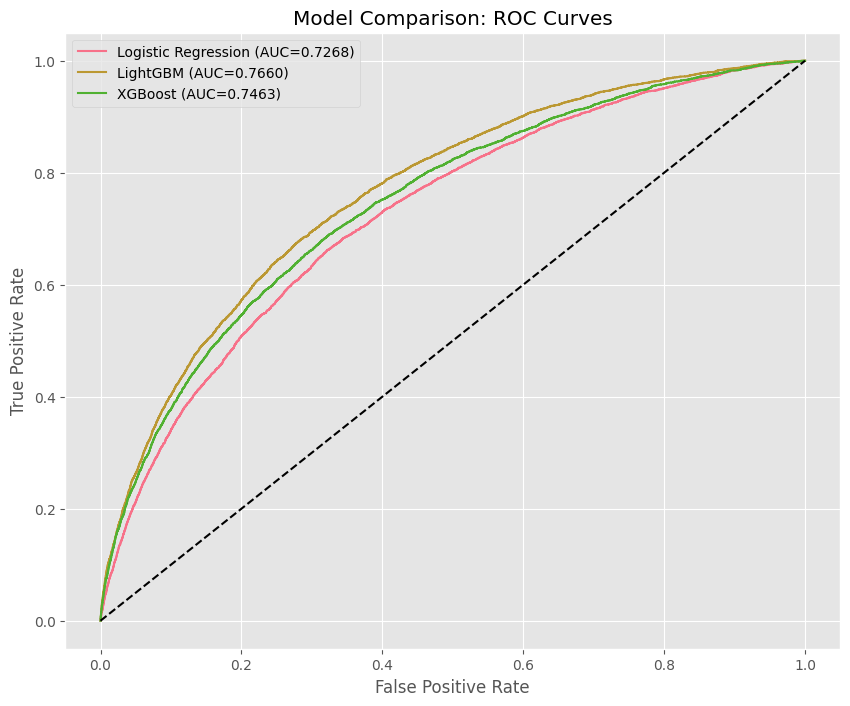

In [25]:
# ROC Curve Comparison
plt.figure(figsize=(10, 8))
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_lr)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_pred_lgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.4f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={auc_lgb:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison: ROC Curves')
plt.legend()
plt.show()

In [26]:
# Performance Table
def get_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }

results = []
results.append(pd.DataFrame([get_metrics(y_val, y_pred_lr)], index=['Logistic Regression']))
results.append(pd.DataFrame([get_metrics(y_val, y_pred_lgb)], index=['LightGBM']))
results.append(pd.DataFrame([get_metrics(y_val, y_pred_xgb)], index=['XGBoost']))

comparison_df = pd.concat(results)
print("Model Performance (Threshold 0.5):")
display(comparison_df)

Model Performance (Threshold 0.5):


,Accuracy,Precision,Recall,F1-Score,AUC
Logistic Regression,0.666439,0.150090,0.671702,0.245356,0.726769
LightGBM,0.757264,0.190251,0.616314,0.290750,0.766032
XGBoost,0.821066,0.218126,0.470695,0.298106,0.746291


In [27]:
# Find Best Threshold using Youden's J (Sensitivity + Specificity - 1)
# Kita gunakan LightGBM sebagai Champion Model untuk ini
fpr, tpr, thresholds = roc_curve(y_val, y_pred_lgb)
j_scores = tpr - fpr
best_ix = np.argmax(j_scores)
best_thresh = thresholds[best_ix]

print(f"Best Threshold (LightGBM): {best_thresh:.4f}")
print(f"J-Score at Threshold: {j_scores[best_ix]:.4f}")

# Re-evaluate with Best Threshold
optimized_metrics = get_metrics(y_val, y_pred_lgb, threshold=best_thresh)
print("\nOptimized LightGBM Metrics:")
print(optimized_metrics)

Best Threshold (LightGBM): 0.4519
J-Score at Threshold: 0.3968

Optimized LightGBM Metrics:
{'Accuracy': 0.7138350974749199, 'Precision': 0.1741373085056997, 'Recall': 0.6799597180261833, 'F1-Score': 0.27726675427069647, 'AUC': 0.7660324382531696}


## 7. Final Submission
*Membuat prediksi pada data test menggunakan threshold optimal.*

In [28]:
# Prepare Test Data
X_test_scaled = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns)

# Predict (Probabilities)
final_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Label (0/1) based on optimized threshold
final_pred_label = (final_pred_proba >= best_thresh).astype(int)

# Create Submission DataFrame
submission = pd.DataFrame({
    'SK_ID_CURR': app_test_eng['SK_ID_CURR'].astype(int),
    'TARGET': final_pred_proba,
    'TARGET_LABEL': final_pred_label # Untuk referensi internal
})

submission[['SK_ID_CURR', 'TARGET']].to_csv('submission_homecredit.csv', index=False)
print("Submission saved: submission_homecredit.csv")
submission.head()

Submission saved: submission_homecredit.csv


,SK_ID_CURR,TARGET,TARGET_LABEL
0,100001,0.185909,0
1,100005,0.485159,1
2,100013,0.036181,0
3,100028,0.208283,0
4,100038,0.695400,1
